<a href="https://colab.research.google.com/github/olmstjamp/Springboard/blob/master/James_Olmstead_Capstone_2_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Capstone Project 2: Fake News Classifier**
By James Olmstead

##Introduction

For my second capstone project, I wanted to utilize a different field of machine learning from my first. To this end, I decided to utilize the natural language toolkit (nltk) library in python to create a fake news classifier. The problem of fake news is quite relevant with the proliferation of social media and with the onslaught of news from a wide range of reputable or not reputable sources. Having a fake news classifier can help social media platforms or other entities flag potentially questionable news stories and either prevent its distribution or warn viewers of its falsity. 

### Importing Libraries

In [1]:
import csv
import nltk
import numpy as np
import re
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.metrics import f1_score, precision_recall_fscore_support, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Data

###Data Description

The data I use comes from a Kaggle competition. There are 3 raw data sets that come from Kaggle that I’ll be using, with descriptions below directly from the website:

https://www.kaggle.com/c/fakenewskdd2020/overview



train.csv: A full training dataset with the following attributes:

*   text: text of the article
*   label: a label that marks the article as potentially unreliable

    *   1: fake
    *   0: true

test.csv: A test dataset with the following attributes:

*   id: the id of the article text
*   text: text of the article

sample_submission.csv: A sample submission with the following attributes.

*   id: the id of the article text from the test data
*   label: a label that marks the article as potentially unreliable  

    *   1: fake
    *   0: true


Note that the test.csv file doesn’t have labels. Since this was a Kaggle competition, I’ll measure my performance of my label predictions of the test set by submitting it to the website in the format demonstrated in sample_submission.csv. Then it will grade the percentage of labels I predicted correctly.  I can also compare my performance to the leaderboard to get a gage on how well I do in predicting the labels. 

###Data Import

In [2]:
#Read in the training data
texts_list = []
labels_list = []
with open('train.csv', "r", encoding='utf-8') as csv_file:
    file = csv.reader(csv_file)
    header = next(file)
    if header != None:
        
        for row in file:
            text = ','.join(row)
            texts_list.append(text[:-2])
            labels_list.append(text[-1:])
            
train_data = pd.DataFrame({'text': texts_list, 'label': labels_list})

While I had no issues importing the training data, the test data proved more difficult. The raw test.csv file initially had all of the articles separated into different cells every time there was a comma, causing some headaches with how it was being read into the notebook. To avoid this I just converted the file from a .csv to a .txt file.This allowed me to read it neatly without needing to worry about all the commas. 

In [3]:
#Reading in the test data
IDs_list = []
texts_list = []
with open('test.txt', "r", encoding='utf-8') as file:
    header = next(file)

    if header != None:
        
        for row in file.readlines():
            text = ''.join(row)

            
            splitted = text.split("\t",1)
            IDs_list.append(int(splitted[0]))
            texts_list.append(splitted[1])

test_data = pd.DataFrame({'id': IDs_list, 'text': texts_list})

Here is what the data looks like once it is read in. By looking over the data quickly it mostly seemed to be celebrity gossip with some political and entertainment news sprinkled in. 

In [4]:
train_data

,text,label
0,Get the latest from TODAY Sign up for our news...,1
1,2d Conan On The Funeral Trump Will Be Invited...,1
2,It’s safe to say that Instagram Stories has fa...,0
3,Much like a certain Amazon goddess with a lass...,0
4,At a time when the perfect outfit is just one ...,0
...,...,...
4332,The storybook romance of WWE stars John Cena a...,0
4333,The actor told friends he’s responsible for en...,0
4334,Sarah Hyland is getting real. The Modern Fami...,0
4335,Production has been suspended on the sixth and...,0


In [5]:
test_data

,id,text
0,2,The 2017 Teen Choice Awards ceremony was held ...
1,3,"The concert, part of “The Joshua Tree Tour,” w..."
2,4,Selena Gomez refuses to talk to her mother abo...
3,5,This is worse than a lump of coal in your stoc...
4,6,Luann De Lesseps is going to rehab after her a...
...,...,...
1242,1244,Get the latest from TODAY Sign up for our news...
1243,1245,Jaden Smith claims that the Four Seasons Hotel...
1244,1246,Overview (3) Mini Bio (1) Faith Hill was bor...
1245,1247,CLOSE Aaron Paul dishes on 'The Path' Aaron P...


### Data Cleaning

Since this data was pre-made for the competition, the amount of cleaning I needed to do was minimal. The only real snag was I found that one of the labels in the train data were labeled as the letter “l” instead of the number “1”, so I changed that.

In [6]:
train_data['label'].value_counts()

0    2588
1    1748
l       1
Name: label, dtype: int64

In [7]:
train_data["label"].replace("l","1", inplace=True)

In [8]:
train_data['label'].value_counts()

0    2588
1    1749
Name: label, dtype: int64

Then I changed the labels from “0” to “Real” and “1” to “Fake” to give the labels a more intuitive meaning.

In [9]:
train_data["label"].replace("1","Fake", inplace=True)
train_data["label"].replace("0","Real", inplace=True)

Finally, I gave the data more conventional names in machine learning.

In [10]:
X_train = train_data['text']
y_train = train_data['label']
X_test = test_data['text']

## Pre-processing

The next step with the data was to break the texts down into simpler components that may otherwise clutter the algorithm. This is called pre-processing, and for this project can be broken down into 4 parts:
1.	Convert everything to lower-case. This way the algorithm won’t distinguish between “One” and “one”, for example.
2.	 Remove special characters like question marks, commas, and periods. This way the algorithm won’t distinguish between “end” and “end!”, for example.
3.	Remove 'Stop Words', which are common words that don’t add anything really meaningful such as “the” and “of”. This helps focus the algorithm on the essential words that make up the meat of the article. The stop words I removed were from the nltk.corpus English library. 
4.	Apply a stemmer to all the words. This is a bit technical, but it essentially boils down a word to its root. An example would be “going” and “goes” being changed to “go”. There are a few ways to do this stemming, but for this project I used a Porter Stemmer.

The function below performs this pre-processing on the X_train and X_test data.


In [11]:
def preprocessing(data, stop=False, stem=False):

    #1. Makes the text all lower case
    data = data.apply(lambda x: x.lower())

    #2. Remove special chars
    data = data.apply(lambda x: re.sub("\\W"," ",x)) 
    data_token = data.apply(lambda x: word_tokenize(x))

    #3. Remove Stop Words
    if stop:
        set(stopwords.words('english'))
        stop_words = set(stopwords.words('english')) 
        data_token = data_token.apply(lambda x: [y for y in x if y not in stop_words])

    #4. Apply Porter Stemmer
    if stem:
        ps = PorterStemmer()
        data_token = data_token.apply(lambda x: [ps.stem(y) for y in x])

    data_train_ready = data_token.apply(lambda x: " ".join(x))

    return data_train_ready

Examples before and after pre-processing. The new data sets are labeled X_train_ready and X_test_ready respectively.

In [12]:
X_train.head()

0    Get the latest from TODAY Sign up for our news...
1    2d  Conan On The Funeral Trump Will Be Invited...
2    It’s safe to say that Instagram Stories has fa...
3    Much like a certain Amazon goddess with a lass...
4    At a time when the perfect outfit is just one ...
Name: text, dtype: object

In [13]:
X_train_ready = preprocessing(X_train, stop=True, stem=True)
X_train_ready.head()

0    get latest today sign newslett one ever truli ...
1                  2d conan funer trump invit conan tb
2    safe say instagram stori far surpass competito...
3    much like certain amazon goddess lasso height ...
4    time perfect outfit one click away high demand...
Name: text, dtype: object

In [14]:
X_test.head()

0    The 2017 Teen Choice Awards ceremony was held ...
1    The concert, part of “The Joshua Tree Tour,” w...
2    Selena Gomez refuses to talk to her mother abo...
3    This is worse than a lump of coal in your stoc...
4    Luann De Lesseps is going to rehab after her a...
Name: text, dtype: object

In [15]:
X_test_ready = preprocessing(X_test, True, True)
X_test_ready.head()

0    2017 teen choic award ceremoni held august 13 ...
1    concert part joshua tree tour slate take place...
2    selena gomez refus talk mother relationship ju...
3    wors lump coal stock exclus learn brad pitt fe...
4    luann de lessep go rehab arrest last week real...
Name: text, dtype: object

## Exploratory Analysis

###Train/Test & Fake/Real splits

The first thing I wanted to look at was to see the training and test sizes and what proportion of the training set was fake and real.

In [16]:
#Creating an 'all_data' set which contains both the training and test sets
#Only really used for the exploratory analysis
test_copy = test_data.copy()
test_copy["label"] = "Test"
all_data = train_data.append(test_copy,ignore_index=True)

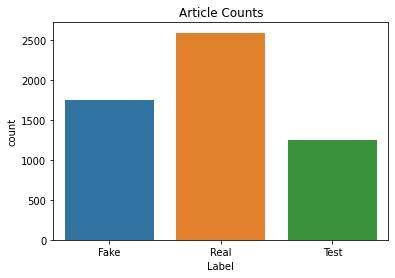

In [17]:
g = sns.countplot(all_data['label'])
plt.title("Article Counts")
plt.xlabel("Label")
plt.show()

These proportions seem pretty standard for a train/test split, with the test set being about 22% of the total data. While I don’t have access to the true labels for the test data, I imagine they will be similarly proportioned to the train set (about 60-40 real-fake).

### Word Counts

Next, I wanted to examine the word counts of the articles to see the overall distribution of word counts, and to see if there were any meaningful differences between the training articles that were fake news, real news, and in the test set. 

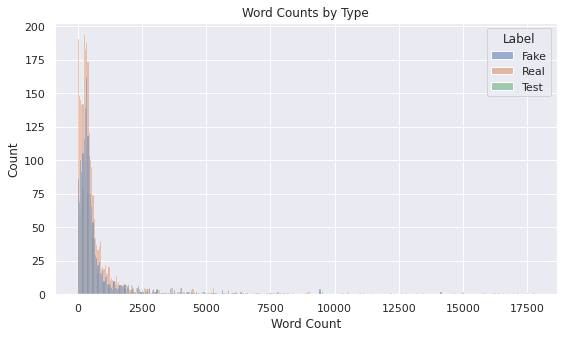

In [18]:
word_counts = pd.DataFrame(all_data["text"].apply(lambda x: len(x.split(" ")))).join(all_data.label)
word_counts.columns = ["Word Count", "Label"]
sns.set(rc={'figure.figsize':(9,5)})
plt.title("Word Counts by Type")
sns.histplot(data = word_counts, x="Word Count", hue="Label")

The only difference in the distributions between the 3 category of articles seems to be just the number of articles in each category. Therefore, it seems safe to put them all together for purposes of examining word counts.

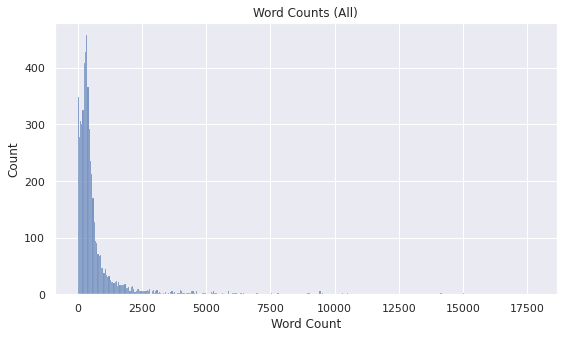

In [19]:
sns.set(rc={'figure.figsize':(9,5)})
plt.title("Word Counts (All)")
sns.histplot(data = word_counts, x="Word Count")

According to the plot above, the bulk of the articles have less than 2500 words but have a long tail. The plots below are a zoomed-in view on the bulk on the left and a zoomed-in view on the long tail. 

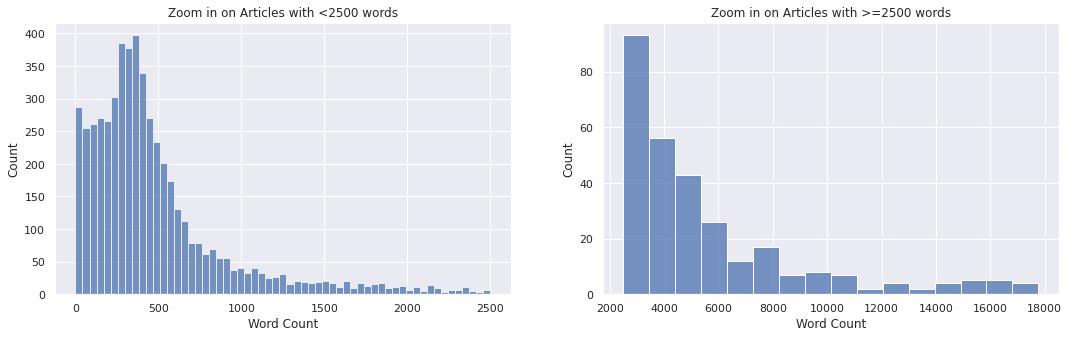

In [20]:
sns.set(rc={'figure.figsize':(18,5)})
plt.subplot(121)
plt.title("Zoom in on Articles with <2500 words")
sns.histplot(data = word_counts, x="Word Count", binrange=(0,2500))
plt.subplot(122)
plt.title("Zoom in on Articles with >=2500 words")
sns.histplot(data = word_counts, x="Word Count", binrange=(2500,max(word_counts["Word Count"])))

### Preprocessed Word Count Examination

Finally, I decided to look at the word counts before and after the pre-processing to see how much of each article was shaved off during the process.

In [21]:
#Making copies just for analysis purposes
X_test_ready_copy = X_test_ready.copy()
X_all_ready = X_train_ready.append(X_test_ready_copy,ignore_index=True)
y_all = y_train.append(test_copy.label,ignore_index=True)

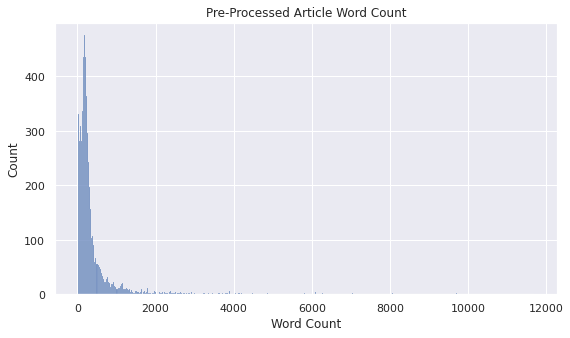

In [22]:
sns.set(rc={'figure.figsize':(9,5)})
word_counts_proc = pd.DataFrame(X_all_ready.apply(lambda x: len(x.split(" ")))).join(y_all)
word_counts_proc.columns = ["Word Count","Label"]
plt.title("Pre-Processed Article Word Count")
sns.histplot(data = word_counts_proc, x="Word Count")

In examining the distribution of word counts, I once again found it useful to zoom in again on the main group (<2500 words) and the tail (>=2500 words).

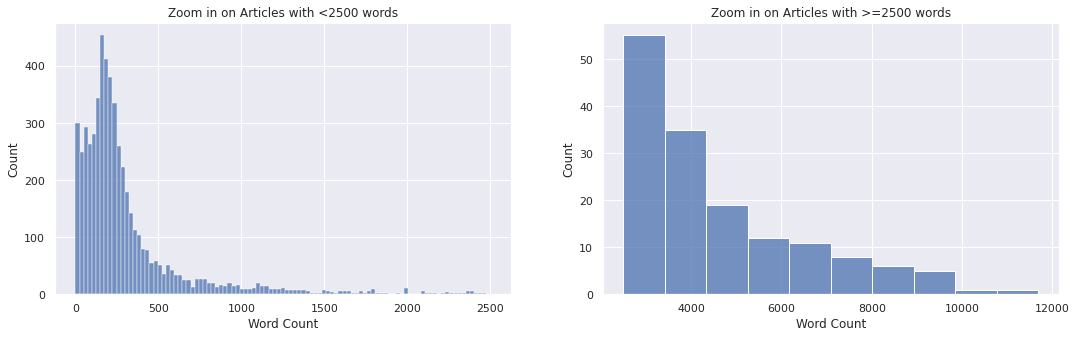

In [23]:
sns.set(rc={'figure.figsize':(18,5)})
plt.subplot(121)
plt.title("Zoom in on Articles with <2500 words")
sns.histplot(data = word_counts_proc, x="Word Count", binrange=(0,2500))
plt.subplot(122)
plt.title("Zoom in on Articles with >=2500 words")
sns.histplot(data = word_counts_proc, x="Word Count", binrange=(2500,max(word_counts_proc["Word Count"])))

The word counts definitely are distributed closer to 0, which is what I expect since we are cutting stop words and such. I also wanted to see how each article’s word count changed. 

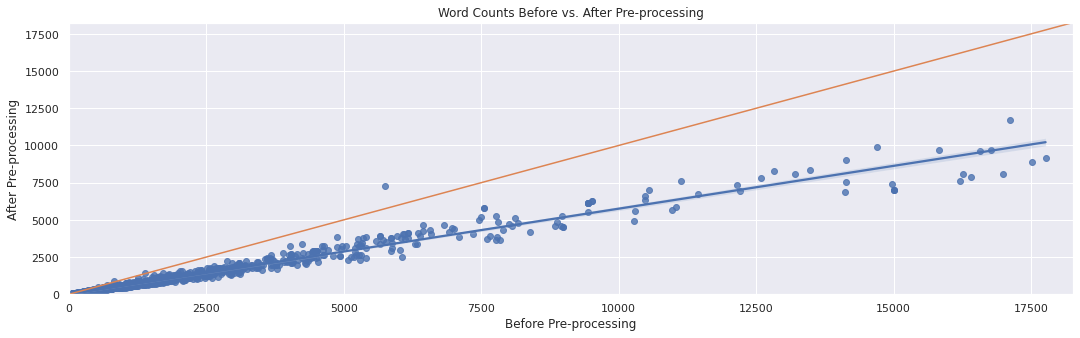

In [24]:
word_counts_compare = pd.DataFrame(word_counts["Word Count"]).join(word_counts_proc,lsuffix="_")
word_counts_compare.columns = ["Before Pre-processing", "After Pre-processing", "Label"]
g = sns.regplot(data = word_counts_compare, x="Before Pre-processing", y="After Pre-processing")
plt.title("Word Counts Before vs. After Pre-processing")
plotlim = max(word_counts_compare["Before Pre-processing"])+500
g.set_xlim(0,plotlim)
g.set_ylim(0,plotlim)
plt.plot(np.arange(0,plotlim),np.arange(0,plotlim))

In the chart above, each point is an article in either the training or test data. Its position on each axis represents its word count before (x-axis) and after (y-axis) pre-processing. The green line is where x=y, or where articles would be if pre-processing wouldn't change the word count, while the blue line is the regression line.

This plot shows mostly what is expected, namely that the pre-processing cuts the number of words. However there seems to be one glaring exception, and possibly more. I investigate this further with the code below by pulling up all the articles where the word count increasing after pre-processing to see how/why it happened.

In [25]:
to_examine = word_counts_compare["Before Pre-processing"] < word_counts_compare["After Pre-processing"]
word_counts_compare[to_examine]

,Before Pre-processing,After Pre-processing,Label
646,23,25,Fake
1049,96,116,Fake
1396,1,2,Fake
1422,825,865,Real
2344,5759,7276,Real
2595,13,20,Real
2803,47,52,Real
3098,44,48,Real
3160,1391,1403,Fake
3662,26,29,Real


Article 2344 seems to be the obvious exception from the plot, but there are a handful more. There doesn't seem to be a pattern with the label, so let's look at the article texts so see what is happening.

In [26]:
for i in word_counts_compare[to_examine].index:
    print("Article ID:", i)
    print("Before Pre-processing:", all_data[to_examine]["text"][i])
    print("After Pre-processing:", X_all_ready[to_examine][i])
    print("\n")

Article ID: 646
Before Pre-processing: A version of this action that uses less javacript and may be usable for those who don't use javascript is available at https://actionnetwork.org/petitions/urgent-new-law-would-charge-protesters-with-terrorism?nowrapper=true&referrer=&source=
After Pre-processing: version action use less javacript may usabl use javascript avail http actionnetwork org petit urgent new law would charg protest terror nowrapp true referr sourc


Article ID: 1049
Before Pre-processing: Streamed live on Mar 16, 2018Reading the Squawker story out today. Yep, our good friend feminism is at it again folks!Please help support this ministry so we can bring more news and inspiration, and expand our reach! You can donate at www.WifeWithAPurpose.com/Support----------------------------------Ayla, is a stay-at-home, homeschooling, home birthing, mother of six children. She holds a Master's degree and is a former Leftist whose pro life and pro family values along with the grace of 

Based on the texts, there are 3 reasons why the pre-processing increased the word count. 
1. A long website link that the pre-processor breaks down into multiple words
2. Poll data that have connected numbers (like dates) that the pre-processor reads as separate numbers.
3. An article in Russian. Not quite sure exactly why but it is likely because we used English stop words. 

While the potential non-English articles appear concerning, I still need to include them in model in case they also appear in the test set. Otherwise it seems fine that the word count increases in these other cases.

## The Model

### New Train/Test

Remember that the test data from Kaggle doesn't have labels. This means we can't gauge how the model performs with unseen data. Therefore we have to create a NEW train and test set out of our current train data so we can have a test set with labels.

The code below splits our training data into a new train and test. This new train and test data is called X2 and y2, but keep in mind going forward that they originate from the original (pre-processed) train data.

In [27]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X_train_ready, y_train, test_size=0.30, random_state=104)
print(X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape)

(3035,) (1302,) (3035,) (1302,)


As shown above, the new training data has 3035 articles with 3035 labels, and the new test data has 1302 articles and 1302 labels.

###Vectorization

The final step before we can create a model is to vectorize the text data. Essentially this is the process by which we convert text to numbers for the model to read in. The [Tf-Idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (term frequency–inverse document frequency) vectorizer takes words in a given article and turns them into the features to go into the model. An example of a specific article is shown below.

In [28]:
vectorizer_example = TfidfVectorizer()

vectorizer_example_fit = vectorizer_example.fit_transform(X2_train)


df = pd.DataFrame(vectorizer_example_fit[0].T.todense(), index=vectorizer_example.get_feature_names(), columns=["TfIdf"])
df = df.sort_values('TfIdf', ascending=False)
df

,TfIdf
cleveland,0.294249
summer,0.293662
movi,0.247122
despic,0.194179
dunkirk,0.188466
...,...
fd_2008_949,0.000000
fda,0.000000
fdgvpxo8at,0.000000
fdoi,0.000000


In [29]:
vectorizer_example_fit.shape

(3035, 39343)

Each feature column of the vectorizer is a given word in our dictionary of words from the text, and each row represents a given article. Note the number of rows in the vectorizer correspond to the number of articles in the train data, and the number of columns are all the possible words found in the train data.

In [30]:
vectorizer_example_fit

<3035x39343 sparse matrix of type '<class 'numpy.float64'>'
	with 691108 stored elements in Compressed Sparse Row format>

This data type is stored as a sparse matrix since it is mostly comprised of 0s. This is because each article only contains a few words in comparison to the huge dictionary of words that is formed from the text. 

###Model Choice

I choose to use the [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) model as it seemed to be the most commonly used model from my research on other fake news classifiers. In the future I might try other models to see if they perform better, but I only use the multinomial NB for purposes of this project.

###Parameter Selection

In order to better optimze the model, I elect to perform a cross-validated grid search with a few parameters. Those parameters are:

*   [Tfidf_ngram_range](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html): Including n-grams of 1, 2, or 3.
*   [nb_alpha](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html): Smoothing parameter for the multinomial nb.



In [31]:
#Assign vectorizer and model to pipeline
pipe = Pipeline([('Tfidf', TfidfVectorizer()),    
                 ('nb', MultinomialNB())])

# Tune GridSearchCV
pipe_params = {'Tfidf__ngram_range': [(1,1),(1,2),(1,3)],
               'nb__alpha': [.36, .6, 1]}

#Using the F1 as the scoring parameter.
gs = GridSearchCV(pipe, param_grid=pipe_params, scoring=make_scorer(f1_score, pos_label="Fake"), cv=5)

gs.fit(X2_train, y2_train);
print("Best score:", gs.best_score_)
print("Train score", gs.score(X2_train, y2_train))

Best score: 0.5262837048887073
Train score 0.7816867469879517


Note that the scores seem a bit low (only getting barely over 50%?). This is because I opt to use the F1 score to optimize the model and can't exactly be interpreted the same as accuracy. I discuss this choice of scoring parameter later on in the notebook in the Model Analysis section.

In [32]:
gs.best_params_

{'Tfidf__ngram_range': (1, 1), 'nb__alpha': 0.36}

These parameters are the best ones from the gridsearch. I'll be using these in my model going forward.

### Feature Selection

The last part of creating my model is to see if we can reduce the dimensionality of the problem. In other words, I'd like to reduce the number of words in the model that aren't very useful in predicting the fake/real label. This is similar to removing the stop words in the pre-processing, but instead I remove words that aren't predictive. First, I need to figure out which words to cut without ruining the model.

#### Chi-Squared Analysis

The metric I use to see which words to cut is the [chi-squared](https://en.wikipedia.org/wiki/Chi-squared_test) statistic. This measures how evenly distributed real and fake news articles are for a given word. For example, if 60% of the total articles are real and 40% are fake, but 90% of the articles with a given word are real and 10% are fake, it will have a high chi-squared statistic.

In [33]:
vectorizer1 = TfidfVectorizer(ngram_range = gs.best_params_['Tfidf__ngram_range'])

vectorizer_all = vectorizer1.fit_transform(X2_train)
vocab_all = vectorizer1.get_feature_names()

#Creating new vectorizers so that the train and test share a vocabulary
vectorizer2 = TfidfVectorizer(ngram_range = gs.best_params_['Tfidf__ngram_range'], vocabulary=vocab_all)
vectorizer3 = TfidfVectorizer(ngram_range = gs.best_params_['Tfidf__ngram_range'], vocabulary=vocab_all)

vectorizer_train = vectorizer2.fit_transform(X2_train)
vectorizer_test = vectorizer3.fit_transform(X2_test)

scores, p_values = chi2(vectorizer_train, y2_train)

Below is a table with each word in our vocabulary with its chi-squared stat and its corresponding p-value. Remember high chi-squared and low p-values are linked and indicate that a given word isn't evenly distributed between fake and real news (though it doesn't say which way it leans.)

In [34]:
chi2_words = pd.DataFrame({"Word": vocab_all, "chi2": scores, "p": p_values}).sort_values("chi2",ascending=False)
chi2_words

,Word,chi2,p
5932,brad,3.520526e+01,2.967212e-09
27185,pitt,3.176604e+01,1.739074e-08
32729,sourc,2.094737e+01,4.720760e-06
18943,joli,1.898240e+01,1.319295e-05
3229,angelina,1.717027e+01,3.417432e-05
...,...,...,...
34258,tabl,1.188018e-08,9.999130e-01
38203,wiig,9.449578e-09,9.999224e-01
4622,batcav,5.514338e-09,9.999408e-01
33495,storybook,4.512456e-09,9.999464e-01


####Cutting Words

Now that we have chi-squared stats and p-values for each word, we can try removing sets of words above a certain p-value and see what happens to our model. The function below does just that by cutting words for a list of p-values and returning the [accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score), [precision, recall, f1, and support](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support) for each p-value and each label.

In [35]:
def P_scorings(P_possible):
    #Matrices that are shape (s, l, p) with s=score type, l=label, p=p-value
    scores_train_all = np.zeros((5,2,len(P_possible)))
    scores_test_all = np.zeros((5,2,len(P_possible)))

    for i,p_cutoff in enumerate(P_possible):
        
        reduced_train = vectorizer_train[:,p_values<p_cutoff]
        reduced_test = vectorizer_test[:,p_values<p_cutoff]

        NB_optimal = MultinomialNB(alpha = gs.best_params_['nb__alpha'])
        NB_optimal.fit(reduced_train, y2_train)


        accuracy_train = NB_optimal.score(reduced_train, y2_train)
        precision_train, recall_train, f1_train, support_train = precision_recall_fscore_support(y2_train, NB_optimal.predict(reduced_train), pos_label="Fake")
        scores_train_all[:,:,i] = np.vstack((np.ones((1,2))*accuracy_train, precision_train, recall_train, f1_train, support_train))


        accuracy_test = NB_optimal.score(reduced_test, y2_test)
        precision_test, recall_test, f1_test, support_test = precision_recall_fscore_support(y2_test, NB_optimal.predict(reduced_test), pos_label="Fake")
        scores_test_all[:,:,i] = np.vstack((np.ones((1,2))*accuracy_test, precision_test, recall_test, f1_test, support_test))

    return scores_train_all, scores_test_all

In [36]:
#List of p-values
P_possible = [0.1, .05, .1, .2, .3, .4, .5, .6, .7, .8, .9, .95, .99]

#Getting the scores from the function
scores_train_all, scores_test_all = P_scorings(P_possible)

Let's plot these results to better visualize what is happening with the different scores as we cut off more and more words from the model. Keep in mind we want to balance 3 competing goals in choosing our p-value:


1.   Minimize p-value (remove as many words as possible).
2.   Maximize train and test scores (best performing model).
3.   Minimize distance between train and test scores (model performance consistent when introducing new data). 



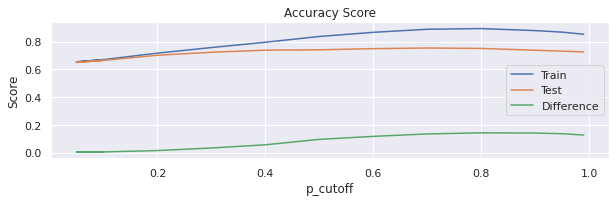

In [37]:
sns.set(rc={'figure.figsize':(22,2.5)})
plt.clf()
plt.subplot(121)
plt.plot(P_possible, scores_train_all[0,0,:], label="Train")
plt.plot(P_possible, scores_test_all[0,0,:], label="Test")
plt.plot(P_possible, scores_train_all[0,0,:]-scores_test_all[0,0,:], label="Difference")
plt.title("Accuracy Score")
plt.xlabel("p_cutoff")
plt.ylabel("Score")
plt.legend()

Accuracy scores behave mostly how we would expect. Generally fewer words mean a less accurate model, but less distance between train and test score. However, the test score actually starts to get slightly worse (at around p=.6) as we include more words in the model. Likely this is a result of overfitting.

Lets see what happens with our other metrics.

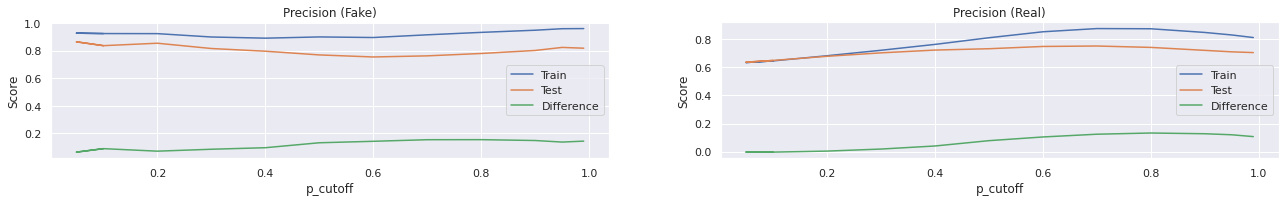

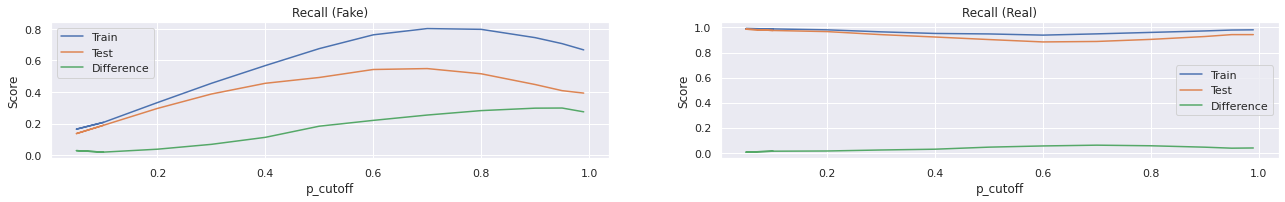

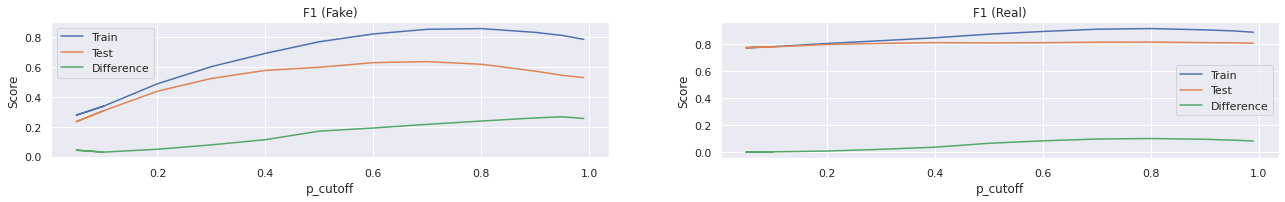

In [38]:
for i, name in enumerate(["Precision", "Recall", "F1"]):
    sns.set(rc={'figure.figsize':(22,2.5)})
    plt.clf()
    plt.subplot(121)
    plt.plot(P_possible, scores_train_all[i+1,0,:], label="Train")
    plt.plot(P_possible, scores_test_all[i+1,0,:], label="Test")
    plt.plot(P_possible, scores_train_all[i+1,0,:]-scores_test_all[i+1,0,:], label="Difference")
    plt.title(name+" (Fake)")
    plt.xlabel("p_cutoff")
    plt.ylabel("Score")
    plt.legend()

    plt.subplot(122)
    plt.plot(P_possible, scores_train_all[i+1,1,:], label="Train")
    plt.plot(P_possible, scores_test_all[i+1,1,:], label="Test")
    plt.plot(P_possible, scores_train_all[i+1,1,:]-scores_test_all[i+1,1,:], label="Difference")
    plt.title(name+" (Real)")
    plt.xlabel("p_cutoff")
    plt.ylabel("Score")
    plt.legend()
    plt.show()

By examining the above plots with our 3 goals in mind, **I ended up going with .7 for my p_cutoff**. It is the best f1 for fake news (which was the bigger problem between the 2 classes.) I chose to prioritize f1 over just precision or recall since both of them seem important for this type of problem in my opinion. (Incorrectly labeling a fake news article as real seems about as problematic as labeling a real news article as fake.) Coincidentally, this .7 is the same as what I'd choose by just looking at accuracy. My guess this is because the disparity in frequencies between real/fake classes isn't that large (only 60-40 real-fake).

Lets see how our vocabulary changes when we remove these words.

In [39]:
p_cutoff_best = .7

word_stats = chi2_words[chi2_words["p"]<p_cutoff_best]
word_stats

,Word,chi2,p
5932,brad,35.205259,2.967212e-09
27185,pitt,31.766036,1.739074e-08
32729,sourc,20.947368,4.720760e-06
18943,joli,18.982403,1.319295e-05
3229,angelina,17.170269,3.417432e-05
...,...,...,...
10015,deboer,0.148568,6.999076e-01
13785,food,0.148531,6.999432e-01
5630,boe,0.148517,6.999566e-01
29707,rink,0.148514,6.999595e-01


By removing words with p<.7, we only have 6601 of the original 39343 words, which is only about 17% of the original vocabulary! This should greatly reduce our likelihood of overfitting while not sacrificing too much in model performance.

###Final Model

Now that we have selected our model type, parameters, and features, we can generate our final model we'll use to submit to Kaggle. 

In [40]:
reduced_vocab = word_stats["Word"]

vectorizer_final_train = TfidfVectorizer(ngram_range = gs.best_params_['Tfidf__ngram_range'], 
                                   vocabulary=reduced_vocab)\
                                    .fit_transform(X2_train)

vectorizer_final_test = TfidfVectorizer(ngram_range = gs.best_params_['Tfidf__ngram_range'], 
                                   vocabulary=reduced_vocab)\
                                    .fit_transform(X2_test)

NB_optimal = MultinomialNB(alpha = gs.best_params_['nb__alpha'])

# fitting the model
NB_optimal.fit(vectorizer_final_train, y2_train)

MultinomialNB(alpha=0.36, class_prior=None, fit_prior=True)

## Model Analysis

Now that we have our final model, let's see if we can get more information on what the model is doing.

### Log-probabilities

 One metric we can examine is the empirical log-probability of each word. These number are all negative, and numbers closer to 0 signify a higher probability that, given a certain class, a given word is present in that class. For example, if an article is real, the word 'show' is very likely to appear in that article, as shown below.

In [41]:
neg_class_sorted_index = (NB_optimal.feature_log_prob_[1, :].argsort())[::-1]
pos_class_sorted_index = (NB_optimal.feature_log_prob_[0, :].argsort())[::-1]

top_realwords = np.take(reduced_vocab, neg_class_sorted_index)
top_fakewords = np.take(reduced_vocab, pos_class_sorted_index)

top_realwords_logprob = np.take(NB_optimal.feature_log_prob_[1, :], neg_class_sorted_index)
top_fakewords_logprob = np.take(NB_optimal.feature_log_prob_[0, :], pos_class_sorted_index)

top_realwords = pd.DataFrame({"Word": top_realwords, "LogProb": top_realwords_logprob})
top_fakewords = pd.DataFrame({"Word": top_fakewords, "LogProb": top_fakewords_logprob})

In [42]:
#Words that are common in real articles.
top_realwords

,Word,LogProb
31830,show,-5.474328
31121,season,-5.537182
21067,like,-5.547098
14755,get,-5.662967
13460,first,-5.729996
...,...,...
9290,credo,-10.416427
36600,unproduct,-10.416427
18355,istockphoto,-10.416427
574,1million,-10.416427


In [43]:
#Words that are common in fake articles
top_fakewords

,Word,LogProb
32729,sourc,-5.459801
5932,brad,-5.594774
19331,kardashian,-5.618375
21067,like,-5.653032
30749,say,-5.682120
...,...,...
36331,undat,-10.189453
14881,gimpl,-10.189453
21322,locationy,-10.189453
10408,desire,-10.189453


###Confusion Matrices

Another way to look at our model performance is to look at a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). This gives us a quick look at how accurate our model is.

In [44]:
pred_train = NB_optimal.predict(vectorizer_final_train)
pred_test = NB_optimal.predict(vectorizer_final_test)

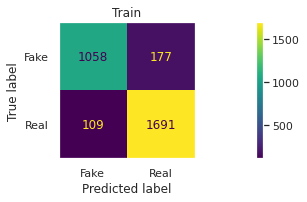

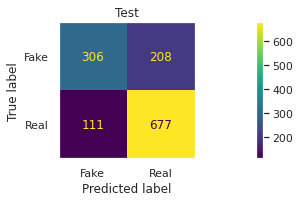

In [45]:
mat = confusion_matrix(y2_train, pred_train, labels=("Fake", "Real"))
ConfusionMatrixDisplay(mat, display_labels=["Fake", "Real"]).plot(values_format='d')
plt.title("Train")
plt.grid(False)
plt.show()

mat = confusion_matrix(y2_test, pred_test, labels=("Fake", "Real"))
ConfusionMatrixDisplay(mat, display_labels=["Fake", "Real"]).plot(values_format='d')
plt.title("Test")
plt.grid(False)
plt.show()

As we can see, the model does pretty well on the training data, but the recall becomes much worse on the test set.

We can also examine how well the model performs if we narrow it down to individual words. The matrices below show us articles with the word "brad" in them, which was our word with the highest chi-squared value from before.

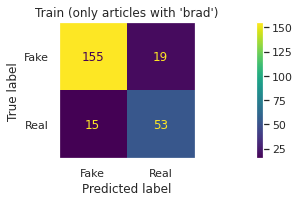

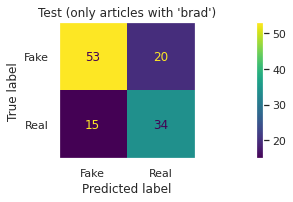

In [46]:
wordtocheck = "brad"
contains_word_train = X2_train.str.contains(wordtocheck)
contains_word_test = X2_test.str.contains(wordtocheck)

mat = confusion_matrix(y2_train[contains_word_train], pred_train[contains_word_train], labels=("Fake", "Real"))
ConfusionMatrixDisplay(mat, display_labels=["Fake", "Real"]).plot(values_format='d')
plt.title("Train "+"(only articles with "+"'brad')")
plt.grid(False)
plt.show()

mat = confusion_matrix(y2_test[contains_word_test], pred_test[contains_word_test], labels=("Fake", "Real"))
ConfusionMatrixDisplay(mat, display_labels=["Fake", "Real"]).plot(values_format='d')
plt.title("Test "+"(only articles with "+"'brad')")
plt.grid(False)
plt.show()

###Word Stats

Lets take a look at both of these elements for each word, the log-probs and the confusion matrix data. 

In [47]:
word_stats = pd.merge(pd.merge(word_stats, top_fakewords, on="Word"), top_realwords, on="Word", suffixes=("_Fake", "_Real"))

In [48]:
def add_stats(w):
    wordtocheck = w["Word"]
    contains_word = X2_train.str.contains(wordtocheck)
    w["TP"], w["FP"], w["FN"], w["TN"] = confusion_matrix(y2_train[contains_word], pred_train[contains_word], labels=("Fake", "Real")).ravel()
    w["TP_norm"], w["FP_norm"], w["FN_norm"], w["TN_norm"] = confusion_matrix(y2_train[contains_word], pred_train[contains_word], labels=("Fake", "Real"), normalize="all").ravel()
    return w

word_stats = word_stats.apply(add_stats, axis=1)

In [49]:
word_stats.sort_values("chi2", ascending=False).head(15)
#Note sorted by chi2

,Word,chi2,p,LogProb_Fake,LogProb_Real,TP,FP,FN,TN,TP_norm,FP_norm,FN_norm,TN_norm
0,brad,35.205259,2.967212e-09,-5.594774,-8.018549,155,19,15,53,0.640496,0.078512,0.061983,0.219008
1,pitt,31.766036,1.739074e-08,-5.687666,-8.125464,139,3,15,15,0.808140,0.017442,0.087209,0.087209
2,sourc,20.947368,4.720760e-06,-5.459801,-6.643690,494,31,46,254,0.598788,0.037576,0.055758,0.307879
3,joli,18.982403,1.319295e-05,-6.016032,-7.906682,113,2,12,17,0.784722,0.013889,0.083333,0.118056
4,angelina,17.170269,3.417432e-05,-6.259558,-8.487052,111,2,12,13,0.804348,0.014493,0.086957,0.094203
5,aniston,14.865728,1.154415e-04,-6.279318,-8.189229,82,4,11,6,0.796117,0.038835,0.106796,0.058252
6,caitlyn,12.990575,3.130628e-04,-6.625143,-9.130981,38,5,6,6,0.690909,0.090909,0.109091,0.109091
7,insid,12.445218,4.190633e-04,-6.053616,-7.349737,311,28,30,175,0.571691,0.051471,0.055147,0.321691
8,jen,12.405813,4.279994e-04,-6.323265,-7.866155,261,48,54,219,0.448454,0.082474,0.092784,0.376289
9,kany,11.405864,7.321264e-04,-6.190414,-7.531865,83,11,14,34,0.584507,0.077465,0.098592,0.239437


Most of the words with high chi2 values seem to correspond more closely to fake news (with the exception of 'season'). This may indicate that most of the most impactful words appear in fake articles. Additionally, words in fake articles don't appear at the same rate in real articles as words in real articles appearing in fake ones. For example, a fake article may have the words "say", "go" and "brad", while a typical real article may only have the words "say" and "go". This makes it tricky to identify fake news articles without these flagging words.

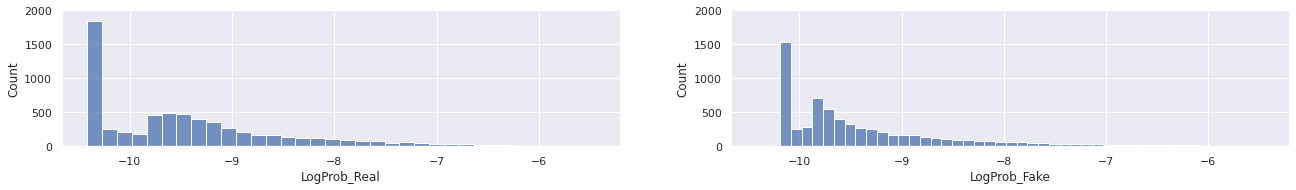

In [50]:
sns.histplot(data = word_stats, x="LogProb_Real")
sns.set(rc={'figure.figsize':(18,5)})
xmin = min(min(word_stats['LogProb_Real']), min(word_stats['LogProb_Fake']))-.25
xmax = max(max(word_stats['LogProb_Real']), max(word_stats['LogProb_Fake']))+.25
ymax = 2000
plt.subplot(121)
g = sns.histplot(data = word_stats, x="LogProb_Real")
g.set_xlim(xmin,xmax)
g.set_ylim(0,ymax)
plt.subplot(122)
g = sns.histplot(data = word_stats, x="LogProb_Fake")
g.set_xlim(xmin,xmax)
g.set_ylim(0,ymax)
plt.show()

##Final Results

###Original Test Set Predictions

After all my analysis, it's time to use the final model to generate predictions for our ORIGINAL test set. Remember, this test data was given to us from Kaggle and hasn't been used at all in our model since it doesn't have labels.

In [51]:
vectorizer_train_toKagg = TfidfVectorizer(ngram_range = gs.best_params_['Tfidf__ngram_range'], vocabulary=reduced_vocab).fit_transform(X_train_ready)
vectorizer_test_toKagg = TfidfVectorizer(ngram_range = gs.best_params_['Tfidf__ngram_range'], vocabulary=reduced_vocab).fit_transform(X_test_ready)

# fitting the model
NB_optimal.fit(vectorizer_train_toKagg, y_train)

pred_toKagg = NB_optimal.predict(vectorizer_test_toKagg)

#Re-labeling Fake and Real as 1 and 0 for the Kaggle submission
pred_toKagg[pred_toKagg == "Fake"] = 1
pred_toKagg[pred_toKagg == "Real"] = 0

### Saving Output

In [52]:
to_submit = pd.DataFrame({'id': test_data['id'], 'label': pred_toKagg})

In [53]:
to_submit.to_csv("to_submit.csv",index=False)

###Kaggle Results

My final model generated a score of 0.75344 from Kaggle, which would place me at #19 on the leaderboard. 

## Conclusion

Overall, I'm pleased with how this Capstone project ended up. Of course, the model didn't end up placing that well compared to the other Kaggle submissions, but it was still a valuable learning experience. If I were to work more on improving the model in the future, I'd definitely try other algorithms besides Multinomial Naive Bayes like a random forest, logistic regression, or SVM. I’d also try to implement some sort of named-entity recognition to capture all of the celebrity names better.  